# **Challenge 4 - Which policies were most effective?**
#### *Contributors of this notebook: Taiyo Nakai, Jiacheng Su; ChatGPT was referenced for parts of Section IV*
#### *December 16, 2023*

## I: Summary
### Procedure
While Power BI has its strengths, we decided that searching for the most effective policies would be easiest using python.
- We created a variable named `Measure` in Power BI, which is the proportion "`Confirmed_Change` (newly confirmed cases over the past week) divided by `Current_Cases` (cases that are currently active)". We have also considered calling this **Growth Rate Index** given its nature.
- After adding `Measure` to a table alongside many columns from the table "Policies", we exported the table to a csv file.
- Using the csv file, we performed **linear regression** with Python (and with help from `scikit-learn`).
### Results
- We are basing our conclusion on the coefficients of our linear regression models.
- **The three most effective policies** were:
    - school closing: no measures
    - public events: require cancelling
    - public information campaigns: coordinated information campaign
- Of our assigned policies, we believe that:
    - 'public information campaigns: coordinated information campaign' was effective
    - 'public events: recommend cancelling' was less effective than outright *cancelling* public events.

## II: Importing Libraries

In [2]:
# Common libraries for data analysis
import numpy as np
import pandas as pd
# Libraries for linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Module for plotting
import matplotlib.pyplot as plt

## III: Exploring and Cleaning Data

The csv file we use below is from our Power BI work; it is a reformatted version of the table "Policies", with additional columns in `Measure` and `Current_Cases`.

In [3]:
csv_file = r"C:\Users\taiyo\Downloads\DS310_Project_policy.csv"
df = pd.read_csv(csv_file)
df

,CountryCode,Measure,WeekOfYear,Confirmed_Change,Current_Cases,C1_School_closing,C2_Workplace_closing,C3_Cancel_public_events,C4_Restrictions_on_gatherings,C5_Close_public_transport,...,E3_Fiscal_measures,E4_International_support,H1_Public_information_campaigns,H2_Testing_policy,H3_Contact_tracing,H4_Emergency_investment_in_healthcare,H5_Investment_in_vaccines,H6_Facial_Coverings,H7_Vaccination_policy,H8_Protection_of_elderly_people
0,CAN,0.055086,1,4736,85975,2,3,2,4,0,...,0.0,0.0,2,2,1,0.0,0.0,3,2,3
1,CAN,0.086308,1,7135,82669,2,3,2,4,0,...,0.0,0.0,2,2,1,0.0,0.0,3,2,3
2,CAN,0.118627,1,10209,86060,2,3,2,4,0,...,0.0,0.0,2,2,1,0.0,0.0,3,2,3
3,CAN,0.085416,2,7220,84527,2,3,2,4,0,...,0.0,0.0,2,2,1,0.0,0.0,3,2,3
4,CAN,0.087592,2,7916,90374,2,3,2,4,0,...,0.0,0.0,2,2,1,0.0,0.0,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4061,SWE,0.028527,52,11383,399029,2,2,2,4,1,...,0.0,0.0,2,2,1,0.0,0.0,0,0,3
4062,SWE,0.015702,53,7002,445939,2,2,2,4,1,...,0.0,0.0,2,2,1,0.0,0.0,0,2,3
4063,SWE,0.016911,53,7100,419844,2,2,2,4,1,...,0.0,0.0,2,2,1,0.0,0.0,0,2,3
4064,SWE,0.020608,53,8834,428675,2,2,2,4,1,...,0.0,0.0,2,2,1,0.0,0.0,0,2,3


In [4]:
df['CountryCode'].unique()

array(['CAN', 'DEU', 'FRA', 'GBR', 'ITA', 'JPN', 'KOR', 'NZL', 'RUS',
       'SWE'], dtype=object)

In [5]:
df.columns

Index(['CountryCode', 'Measure', 'WeekOfYear', 'Confirmed_Change',
       'Current_Cases', 'C1_School_closing', 'C2_Workplace_closing',
       'C3_Cancel_public_events', 'C4_Restrictions_on_gatherings',
       'C5_Close_public_transport', 'C6_Stay_at_home_requirements',
       'C7_Restrictions_on_internal_movement',
       'C8_International_travel_controls', 'E1_Income_support',
       'E2_Debt_contract_relief', 'E3_Fiscal_measures',
       'E4_International_support', 'H1_Public_information_campaigns',
       'H2_Testing_policy', 'H3_Contact_tracing',
       'H4_Emergency_investment_in_healthcare', 'H5_Investment_in_vaccines',
       'H6_Facial_Coverings', 'H7_Vaccination_policy',
       'H8_Protection_of_elderly_people'],
      dtype='object')

We do not need to know the `WeekofYear` for our purposes, and `Measure` is derived from `Confirmed_Change` and `Current_Cases`.

In [6]:
columns_to_drop = [2, 3, 4]
df1 = df.drop(df.columns[columns_to_drop], axis=1)
df1.head()

,CountryCode,Measure,C1_School_closing,C2_Workplace_closing,C3_Cancel_public_events,C4_Restrictions_on_gatherings,C5_Close_public_transport,C6_Stay_at_home_requirements,C7_Restrictions_on_internal_movement,C8_International_travel_controls,...,E3_Fiscal_measures,E4_International_support,H1_Public_information_campaigns,H2_Testing_policy,H3_Contact_tracing,H4_Emergency_investment_in_healthcare,H5_Investment_in_vaccines,H6_Facial_Coverings,H7_Vaccination_policy,H8_Protection_of_elderly_people
0,CAN,0.055086,2,3,2,4,0,1,2,4,...,0.0,0.0,2,2,1,0.0,0.0,3,2,3
1,CAN,0.086308,2,3,2,4,0,1,2,4,...,0.0,0.0,2,2,1,0.0,0.0,3,2,3
2,CAN,0.118627,2,3,2,4,0,1,2,4,...,0.0,0.0,2,2,1,0.0,0.0,3,2,3
3,CAN,0.085416,2,3,2,4,0,1,2,4,...,0.0,0.0,2,2,1,0.0,0.0,3,2,3
4,CAN,0.087592,2,3,2,4,0,1,2,4,...,0.0,0.0,2,2,1,0.0,0.0,3,2,3


### Dropping missing values

In [7]:
df1.isnull().sum()

CountryCode                               0
Measure                                   2
C1_School_closing                         0
C2_Workplace_closing                      0
C3_Cancel_public_events                   0
C4_Restrictions_on_gatherings             0
C5_Close_public_transport                 0
C6_Stay_at_home_requirements              0
C7_Restrictions_on_internal_movement      0
C8_International_travel_controls          0
E1_Income_support                         0
E2_Debt_contract_relief                   0
E3_Fiscal_measures                       49
E4_International_support                  4
H1_Public_information_campaigns           0
H2_Testing_policy                         0
H3_Contact_tracing                        0
H4_Emergency_investment_in_healthcare    15
H5_Investment_in_vaccines                 8
H6_Facial_Coverings                       0
H7_Vaccination_policy                     0
H8_Protection_of_elderly_people           0
dtype: int64

In [8]:
df1 = df1.dropna()
df1.isnull().sum()

CountryCode                              0
Measure                                  0
C1_School_closing                        0
C2_Workplace_closing                     0
C3_Cancel_public_events                  0
C4_Restrictions_on_gatherings            0
C5_Close_public_transport                0
C6_Stay_at_home_requirements             0
C7_Restrictions_on_internal_movement     0
C8_International_travel_controls         0
E1_Income_support                        0
E2_Debt_contract_relief                  0
E3_Fiscal_measures                       0
E4_International_support                 0
H1_Public_information_campaigns          0
H2_Testing_policy                        0
H3_Contact_tracing                       0
H4_Emergency_investment_in_healthcare    0
H5_Investment_in_vaccines                0
H6_Facial_Coverings                      0
H7_Vaccination_policy                    0
H8_Protection_of_elderly_people          0
dtype: int64

## IV: Linear Regression

### **1. Looking at all 10 countries**

#### Splitting the data for linear regression (using scikit learn)

In [40]:
X = df1.drop(['CountryCode', 'Measure'], axis=1)
y = df1['Measure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [42]:
y_pred = model.predict(X_test)

In [43]:
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.002915484886248852


#### Plotting the model

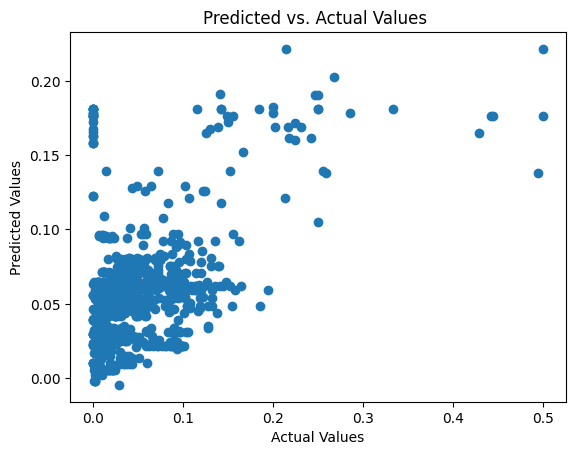

In [44]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values ')
plt.show()

### **2: Looking at individual countries**

In [14]:
country_list = df1['CountryCode'].unique()
country_list

array(['CAN', 'DEU', 'FRA', 'GBR', 'ITA', 'JPN', 'KOR', 'NZL', 'RUS',
       'SWE'], dtype=object)

The cell below contains a slightly modified version of the code in the previous section.

The MSE for CAN is 0.003176507111454662
The MSE for DEU is 0.009078546117255145
The MSE for FRA is 0.002050099983076801
The MSE for GBR is 0.0034333515420441074
The MSE for ITA is 0.002470476868322675
The MSE for JPN is 0.0024788640930212833
The MSE for KOR is 0.010491414897939201
The MSE for NZL is 0.0014074754393910757
The MSE for RUS is 0.0032272763584100996
The MSE for SWE is 0.003879471948132493


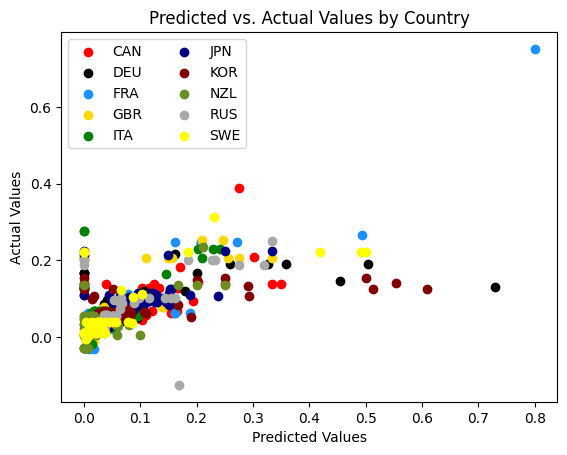

In [15]:
colors = ['red','black','dodgerblue','gold','green','navy','maroon','olivedrab','darkgray','yellow']
for i, country in enumerate(country_list):
    X = df1[df1['CountryCode'] == country].drop(['CountryCode', 'Measure'], axis=1)
    y = df1[df1['CountryCode'] == country]['Measure'] #Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'The MSE for {country} is {mse}')
    plt.scatter(y_test, y_pred, color=colors[i], label=country)
legend = plt.legend(ncol=2)
for i, country in enumerate(country_list):
    legend.get_texts()[i].set_text(country)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs. Actual Values by Country')
plt.show()

### **3: Using one-hot encoding**

Given that most of the columns we are working with are dummy variables, we decided that performing **one-hot encoding** (converting all dummy variables to booleans) would be most appropriate.

In [47]:
df2 = df1.drop(['CountryCode','Measure','E3_Fiscal_measures', 'E4_International_support', 'H4_Emergency_investment_in_healthcare', 'H5_Investment_in_vaccines'], axis=1)
df2 = df2.astype(str)
df2 = pd.get_dummies(df2)
columns_to_concat = ['CountryCode','Measure','E3_Fiscal_measures', 'E4_International_support', 'H4_Emergency_investment_in_healthcare', 'H5_Investment_in_vaccines']
df2 = pd.concat([df1[columns_to_concat], df2], axis=1)
df2.head(10)

,CountryCode,Measure,E3_Fiscal_measures,E4_International_support,H4_Emergency_investment_in_healthcare,H5_Investment_in_vaccines,C1_School_closing_0,C1_School_closing_1,C1_School_closing_2,C1_School_closing_3,...,H6_Facial_Coverings_4,H7_Vaccination_policy_0,H7_Vaccination_policy_1,H7_Vaccination_policy_2,H7_Vaccination_policy_3,H7_Vaccination_policy_4,H8_Protection_of_elderly_people_0,H8_Protection_of_elderly_people_1,H8_Protection_of_elderly_people_2,H8_Protection_of_elderly_people_3
0,CAN,0.055086,0.0,0.0,0.0,0.0,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
1,CAN,0.086308,0.0,0.0,0.0,0.0,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
2,CAN,0.118627,0.0,0.0,0.0,0.0,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
3,CAN,0.085416,0.0,0.0,0.0,0.0,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
4,CAN,0.087592,0.0,0.0,0.0,0.0,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
5,CAN,0.093797,0.0,0.0,0.0,0.0,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
6,CAN,0.090499,0.0,0.0,0.0,12613504.0,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
7,CAN,0.095525,0.0,0.0,0.0,0.0,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
8,CAN,0.096059,0.0,0.0,0.0,0.0,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
9,CAN,0.110563,0.0,0.0,0.0,0.0,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True


The MSE for CAN is 0.002805759193460995
The MSE for DEU is 0.0052452268177898
The MSE for FRA is 0.0017072080348820235
The MSE for GBR is 0.0035628443730824745
The MSE for ITA is 0.0016788880686780334
The MSE for JPN is 0.0024787309164623537
The MSE for KOR is 0.010632129694238282
The MSE for NZL is 0.0009569884469560289
The MSE for RUS is 0.0025137279482783646
The MSE for SWE is 0.003892286204517656


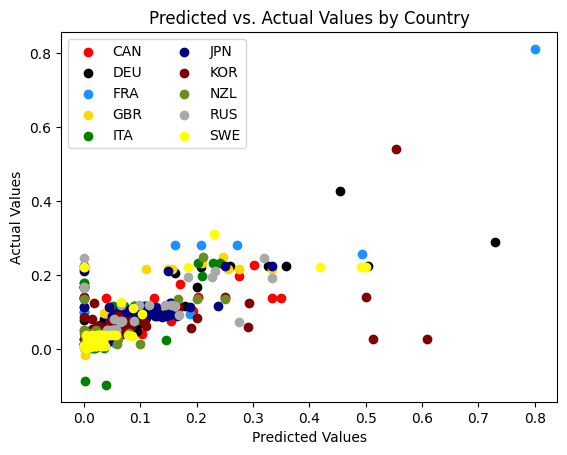

In [116]:
colors = ['red','black','dodgerblue','gold','green','navy','maroon','olivedrab','darkgray','yellow']
coefficients = []
for i, country in enumerate(country_list):
    X = df2[df2['CountryCode'] == country].drop(['CountryCode', 'Measure'], axis=1)
    y = df2[df2['CountryCode'] == country]['Measure'] #Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    coefficients.append(model.coef_)
    mse = mean_squared_error(y_test, y_pred)
    print(f'The MSE for {country} is {mse}')
    plt.scatter(y_test, y_pred, color=colors[i], label=country)
legend = plt.legend(ncol=2)
for i, country in enumerate(country_list):
    legend.get_texts()[i].set_text(country)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs. Actual Values by Country')
plt.show()

Here is the same graph, but without differentiating by country.

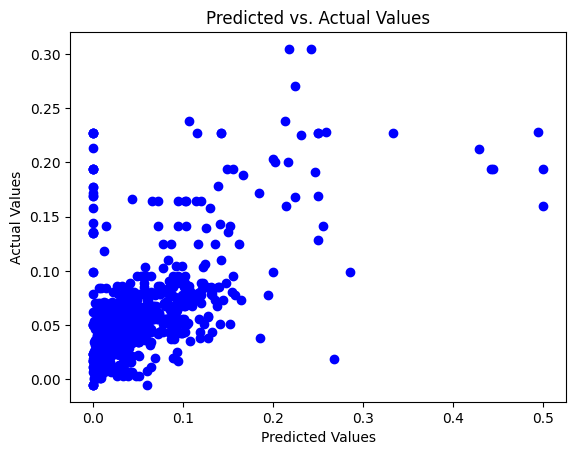

In [117]:
coefficients1=[]
X = df2.drop(['CountryCode', 'Measure'], axis=1)
y = df2['Measure'] #Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
coefficients1.append(model.coef_)
mse = mean_squared_error(y_test, y_pred)
plt.scatter(y_test, y_pred, color='b')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs. Actual Values')
plt.show()

### **4: Finding the smallest coefficients of the model**

Since we are trying to find the policies that *reduce* `Measure` (a proportion akin to the **growth rate** of COVID-19 cases), we will find which coefficients of the linear regression model in part 3 are the smallest.

For instance, a negative coefficient for `C3_Cancel_public_events_2` would suggest that requiring public events to be cancelled reduces the growth rate of COVID-19 cases.

In [57]:
df3 = pd.DataFrame(coefficients, index=country_list, columns=df2.columns[2:])
df3.head(10)

,E3_Fiscal_measures,E4_International_support,H4_Emergency_investment_in_healthcare,H5_Investment_in_vaccines,C1_School_closing_0,C1_School_closing_1,C1_School_closing_2,C1_School_closing_3,C2_Workplace_closing_0,C2_Workplace_closing_1,...,H6_Facial_Coverings_4,H7_Vaccination_policy_0,H7_Vaccination_policy_1,H7_Vaccination_policy_2,H7_Vaccination_policy_3,H7_Vaccination_policy_4,H8_Protection_of_elderly_people_0,H8_Protection_of_elderly_people_1,H8_Protection_of_elderly_people_2,H8_Protection_of_elderly_people_3
CAN,2.025994e-11,-1.483144e-11,9.779234e-12,-1.720561e-11,-0.019564,-5.084683e-13,2.675053e-02,-7.186700e-03,0.013885,-1.888205e-12,...,0.000000,0.002482,0.000000,-0.005742,0.003260,0.00000,-0.000399,0.011172,0.055521,-0.066294
DEU,7.320644e-10,-1.303154e-11,-4.740325e-10,-2.909936e-11,-0.263022,9.402456e-02,8.742406e-02,8.157375e-02,0.025449,9.427042e-13,...,0.000000,-0.009282,0.000000,-0.003504,0.012786,0.00000,0.044790,-0.019341,0.002435,-0.027884
FRA,1.671739e-08,-1.099864e-11,-4.420528e-09,9.725419e-10,-0.014733,4.893037e-03,1.019559e-03,8.820243e-03,0.003660,-1.352131e-02,...,0.005488,0.008186,0.000000,-0.002010,-0.006176,0.00000,0.072442,0.000000,-0.072966,0.000525
GBR,-1.503792e-11,-3.570555e-11,8.391342e-11,4.169923e-10,-0.036966,1.153898e-02,1.173876e-02,1.368828e-02,0.076275,-6.831958e-02,...,0.000000,0.003052,0.000000,0.000000,-0.001472,-0.00158,0.009095,0.000000,-0.007424,-0.001670
ITA,5.820273e-10,-5.734818e-11,-1.984594e-11,1.861300e-09,0.054845,-1.006911e-02,-4.357538e-02,-1.200883e-03,-0.211263,5.901576e-02,...,-0.060705,0.022481,0.000000,-0.022481,0.000000,0.00000,0.054845,0.000000,0.000000,-0.054845
JPN,-3.790426e-11,1.022112e-11,1.917244e-09,4.375729e-11,-0.017414,1.806906e-02,-5.169606e-13,-6.547933e-04,-0.002460,2.459610e-03,...,0.000000,-0.003149,0.003149,0.000000,0.000000,0.00000,-0.005194,-0.015859,0.000000,0.021053
KOR,9.335746e-11,-4.659743e-11,-5.215147e-09,-2.993383e-11,-0.014357,-2.220847e-04,2.556186e-02,-1.098253e-02,-0.018211,-1.076028e-03,...,0.000000,0.006001,0.000000,0.009157,-0.015158,0.00000,-0.018211,0.000000,0.031660,-0.013448
NZL,7.874492e-10,-3.888952e-10,1.849215e-15,-4.856231e-10,-0.023917,2.965389e-04,1.500704e-02,8.613336e-03,-0.059589,3.670233e-02,...,0.000000,-0.011434,-0.015196,0.026630,0.000000,0.00000,0.159084,-0.081059,-0.059442,-0.018583
RUS,-4.171355e-12,-8.669999e-10,4.027648e-11,-3.413364e-10,0.132709,-3.998662e-02,-3.190595e-02,-6.081638e-02,-0.016959,-1.072746e-03,...,0.000000,-0.014158,0.008376,0.000000,0.005782,0.00000,0.041129,-0.126557,0.039639,0.045789
SWE,5.478490e-11,-2.906438e-10,2.132557e-11,-4.186408e-14,0.019710,-7.608115e-03,-1.210189e-02,-3.975986e-15,-0.005521,2.151816e-03,...,0.000000,0.004077,0.000000,-0.004077,0.000000,0.00000,0.041018,0.000000,-0.020227,-0.020791


#### Which policies have the lowest coefficients (i.e. growth rates)?

In [59]:
df4 = pd.DataFrame(coefficients1, columns=df2.columns[2:])
df4.head(10)

,E3_Fiscal_measures,E4_International_support,H4_Emergency_investment_in_healthcare,H5_Investment_in_vaccines,C1_School_closing_0,C1_School_closing_1,C1_School_closing_2,C1_School_closing_3,C2_Workplace_closing_0,C2_Workplace_closing_1,...,H6_Facial_Coverings_4,H7_Vaccination_policy_0,H7_Vaccination_policy_1,H7_Vaccination_policy_2,H7_Vaccination_policy_3,H7_Vaccination_policy_4,H8_Protection_of_elderly_people_0,H8_Protection_of_elderly_people_1,H8_Protection_of_elderly_people_2,H8_Protection_of_elderly_people_3
0,-1.280464e-11,3.598205e-12,2.364672e-11,-6.204145e-11,-0.015638,0.018549,0.002724,-0.005635,0.007186,-0.01469,...,-0.027566,0.014654,0.014255,0.00284,-0.001214,-0.030535,0.020891,-0.007987,-0.012682,-0.000222


In [119]:
df4.iloc[0].rank().sort_values(ascending=False)

C8_International_travel_controls_1    65.0
E1_Income_support_0                   64.0
H2_Testing_policy_1                   63.0
H1_Public_information_campaigns_2     62.0
H2_Testing_policy_2                   61.0
                                      ... 
H6_Facial_Coverings_4                  5.0
E1_Income_support_2                    4.0
H7_Vaccination_policy_4                3.0
H1_Public_information_campaigns_1      2.0
H2_Testing_policy_0                    1.0
Name: 0, Length: 65, dtype: float64

There is a problem with this list. `E1_Income_support_0`, which represents "no income support", appears to be the second best policy.

To solve this, we will list the best policies by country, then tally them based on a scoring system (similar to MVP voting in sports)

In [132]:
policies = []
for index, rows in df3.iterrows():
    r = rows.nsmallest(5).index.tolist()
    policies.append(r)
policies = pd.DataFrame(policies, index=country_list)
policies.index.name = 'Country Code'
# This is a rudimentary solution to the "scoring system". We make more duplicate columns for the 
# better policies, then tally over the entire table.
policies['0.1'] = policies.loc[:,0]
policies['0.2'] = policies.loc[:,0]
policies['0.3'] = policies.loc[:,0]
policies['0.4'] = policies.loc[:,0]
policies['1.1'] = policies.loc[:,1]
policies['1.2'] = policies.loc[:,1]
policies['1.3'] = policies.loc[:,1]
policies['2.1'] = policies.loc[:,2]
policies['2.2'] = policies.loc[:,2]
policies['3.1'] = policies.loc[:,3]
policies

,0,1,2,3,4,0.1,0.2,0.3,0.4,1.1,1.2,1.3,2.1,2.2,3.1
Country Code,,,,,,,,,,,,,,,
CAN,H8_Protection_of_elderly_people_3,C4_Restrictions_on_gatherings_3,H6_Facial_Coverings_1,H2_Testing_policy_1,H6_Facial_Coverings_2,H8_Protection_of_elderly_people_3,H8_Protection_of_elderly_people_3,H8_Protection_of_elderly_people_3,H8_Protection_of_elderly_people_3,C4_Restrictions_on_gatherings_3,C4_Restrictions_on_gatherings_3,C4_Restrictions_on_gatherings_3,H6_Facial_Coverings_1,H6_Facial_Coverings_1,H2_Testing_policy_1
DEU,C1_School_closing_0,H1_Public_information_campaigns_2,H6_Facial_Coverings_2,C8_International_travel_controls_1,H8_Protection_of_elderly_people_3,C1_School_closing_0,C1_School_closing_0,C1_School_closing_0,C1_School_closing_0,H1_Public_information_campaigns_2,H1_Public_information_campaigns_2,H1_Public_information_campaigns_2,H6_Facial_Coverings_2,H6_Facial_Coverings_2,C8_International_travel_controls_1
FRA,H1_Public_information_campaigns_1,C4_Restrictions_on_gatherings_4,C3_Cancel_public_events_2,C3_Cancel_public_events_1,H8_Protection_of_elderly_people_2,H1_Public_information_campaigns_1,H1_Public_information_campaigns_1,H1_Public_information_campaigns_1,H1_Public_information_campaigns_1,C4_Restrictions_on_gatherings_4,C4_Restrictions_on_gatherings_4,C4_Restrictions_on_gatherings_4,C3_Cancel_public_events_2,C3_Cancel_public_events_2,C3_Cancel_public_events_1
GBR,C2_Workplace_closing_1,C1_School_closing_0,C7_Restrictions_on_internal_movement_2,C7_Restrictions_on_internal_movement_1,E2_Debt_contract_relief_0,C2_Workplace_closing_1,C2_Workplace_closing_1,C2_Workplace_closing_1,C2_Workplace_closing_1,C1_School_closing_0,C1_School_closing_0,C1_School_closing_0,C7_Restrictions_on_internal_movement_2,C7_Restrictions_on_internal_movement_2,C7_Restrictions_on_internal_movement_1
ITA,C2_Workplace_closing_0,C7_Restrictions_on_internal_movement_0,E2_Debt_contract_relief_1,C6_Stay_at_home_requirements_2,C4_Restrictions_on_gatherings_0,C2_Workplace_closing_0,C2_Workplace_closing_0,C2_Workplace_closing_0,C2_Workplace_closing_0,C7_Restrictions_on_internal_movement_0,C7_Restrictions_on_internal_movement_0,C7_Restrictions_on_internal_movement_0,E2_Debt_contract_relief_1,E2_Debt_contract_relief_1,C6_Stay_at_home_requirements_2
JPN,H1_Public_information_campaigns_2,E1_Income_support_1,C1_School_closing_0,H8_Protection_of_elderly_people_1,E2_Debt_contract_relief_2,H1_Public_information_campaigns_2,H1_Public_information_campaigns_2,H1_Public_information_campaigns_2,H1_Public_information_campaigns_2,E1_Income_support_1,E1_Income_support_1,E1_Income_support_1,C1_School_closing_0,C1_School_closing_0,H8_Protection_of_elderly_people_1
KOR,C4_Restrictions_on_gatherings_0,C3_Cancel_public_events_0,H1_Public_information_campaigns_2,C7_Restrictions_on_internal_movement_1,C6_Stay_at_home_requirements_1,C4_Restrictions_on_gatherings_0,C4_Restrictions_on_gatherings_0,C4_Restrictions_on_gatherings_0,C4_Restrictions_on_gatherings_0,C3_Cancel_public_events_0,C3_Cancel_public_events_0,C3_Cancel_public_events_0,H1_Public_information_campaigns_2,H1_Public_information_campaigns_2,C7_Restrictions_on_internal_movement_1
NZL,E1_Income_support_0,H8_Protection_of_elderly_people_1,H2_Testing_policy_2,C2_Workplace_closing_0,H8_Protection_of_elderly_people_2,E1_Income_support_0,E1_Income_support_0,E1_Income_support_0,E1_Income_support_0,H8_Protection_of_elderly_people_1,H8_Protection_of_elderly_people_1,H8_Protection_of_elderly_people_1,H2_Testing_policy_2,H2_Testing_policy_2,C2_Workplace_closing_0
RUS,H8_Protection_of_elderly_people_1,H3_Contact_tracing_0,C1_School_closing_3,C4_Restrictions_on_gatherings_1,C1_School_closing_1,H8_Protection_of_elderly_people_1,H8_Protection_of_elderly_people_1,H8_Protection_of_elderly_people_1,H8_Protection_of_elderly_people_1,H3_Contact_tracing_0,H3_Contact_tracing_0,H3_Contact_tracing_0,C1_School_closing_3,C1_School_closing_3,C4_Restrictions_on_gatherings_1


In [135]:
stacked_list = policies.stack().value_counts().head(10)
stacked_list
#stacked_list.to_csv(path_or_buf=r"C:\Users\taiyo\OneDrive\Desktop\BU files\2023-2024\DS310\projectstacked1.csv")

C1_School_closing_0                  12
H1_Public_information_campaigns_2    12
H8_Protection_of_elderly_people_1    11
H8_Protection_of_elderly_people_3     7
C3_Cancel_public_events_2             7
C2_Workplace_closing_0                7
C4_Restrictions_on_gatherings_3       6
C4_Restrictions_on_gatherings_0       6
H1_Public_information_campaigns_1     5
H1_Public_information_campaigns_0     5
Name: count, dtype: int64

## V: Conclusion

Based on the scores above, we conclude that
- `C1_School_closing_0`: taking **no measures** towards school closing
- `H1_Public_information_campaigns_2`: running a **coordinated information campaign**

were the two most effective policies in reducing the growth rate of COVID-19 in the ten countries we examined.

Our assigned policies are "Public events - recommend cancelling (1)" and "public information campaigns: coordinated information campaign (2)". Based on our analysis, we can say that the latter was an effective policy, while the former was either less effective than requiring cancelling, or was simply less commonly implemented at all.

In [137]:
df4[['C1_School_closing_0', 'H1_Public_information_campaigns_2', 'C3_Cancel_public_events_1']]

,C1_School_closing_0,H1_Public_information_campaigns_2,C3_Cancel_public_events_1
0,-0.015638,0.039219,0.008464


Because of how we determined the most effective policies, the growth rates of our "two best" policies are not the two *lowest*. However, they were effective for more countries compared to the other policies.

## Extra: A portion of our original solution (for documentation purposes)

By tallying the 3 most effective policies of each country, we see several that are more common. The most commonly observed are
- `C1_School_closing_0`: taking **no measures** towards school closing
- `H1_Public_information_campaigns_2`: running a **coordinated information campaign**

and the next most observed are
- `C3_Cancel_public_events_2`: **require cancelling public events**
- `H8_Protection_of_elderly people_1`: taking limited measures towards protecting the elderly (no description was provided in Piazza)

In [123]:
policies = []
for index, rows in df3.iterrows():
    r = rows.nsmallest(7).index.tolist()
    policies.append(r)
policies = pd.DataFrame(policies, index=country_list)
policies.stack().value_counts().head(10)

C1_School_closing_0                       4
C3_Cancel_public_events_2                 4
H8_Protection_of_elderly_people_3         3
H8_Protection_of_elderly_people_1         3
H6_Facial_Coverings_2                     3
C4_Restrictions_on_gatherings_0           3
H1_Public_information_campaigns_2         3
H8_Protection_of_elderly_people_2         3
C7_Restrictions_on_internal_movement_1    3
C7_Restrictions_on_internal_movement_2    2
Name: count, dtype: int64

When expanding to the 7 most commonly effective policies, we see that the top 2 are also in the top 4 from before.

In [124]:
policies = []
for index, rows in df3.iterrows():
    r = rows.nsmallest(15).index.tolist()
    policies.append(r)
policies = pd.DataFrame(policies, index=country_list)
policies.stack().value_counts().head(10)

C3_Cancel_public_events_2                 7
C7_Restrictions_on_internal_movement_1    6
H6_Facial_Coverings_2                     6
C1_School_closing_0                       6
C5_Close_public_transport_1               5
C2_Workplace_closing_0                    5
E1_Income_support_1                       4
H8_Protection_of_elderly_people_1         4
C4_Restrictions_on_gatherings_4           4
H1_Public_information_campaigns_2         4
Name: count, dtype: int64

In [125]:
policies.shape

(10, 15)

In [126]:
policies.index.name = 'Country Code'
#policies.rename(columns={'0':'1','1':'2','2':'3','3':'4','4':'5','5':'6','6':'7','7':'8','8':'9','9':'10','10':'11','11':'12','12':'13','13':'14','14':'15'}, inplace=True)
policies

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Country Code,,,,,,,,,,,,,,,
CAN,H8_Protection_of_elderly_people_3,C4_Restrictions_on_gatherings_3,H6_Facial_Coverings_1,H2_Testing_policy_1,H6_Facial_Coverings_2,C4_Restrictions_on_gatherings_0,C1_School_closing_0,C7_Restrictions_on_internal_movement_2,E2_Debt_contract_relief_1,C8_International_travel_controls_4,E1_Income_support_0,C6_Stay_at_home_requirements_1,C2_Workplace_closing_3,C1_School_closing_3,H7_Vaccination_policy_2
DEU,C1_School_closing_0,H1_Public_information_campaigns_2,H6_Facial_Coverings_2,C8_International_travel_controls_1,H8_Protection_of_elderly_people_3,C4_Restrictions_on_gatherings_4,C3_Cancel_public_events_2,C4_Restrictions_on_gatherings_3,H8_Protection_of_elderly_people_1,C3_Cancel_public_events_1,E1_Income_support_2,C2_Workplace_closing_2,C2_Workplace_closing_3,C5_Close_public_transport_1,C8_International_travel_controls_3
FRA,H1_Public_information_campaigns_1,C4_Restrictions_on_gatherings_4,C3_Cancel_public_events_2,C3_Cancel_public_events_1,H8_Protection_of_elderly_people_2,H1_Public_information_campaigns_0,H2_Testing_policy_0,C8_International_travel_controls_0,H3_Contact_tracing_0,H6_Facial_Coverings_0,C1_School_closing_0,C2_Workplace_closing_1,H2_Testing_policy_1,E2_Debt_contract_relief_0,C7_Restrictions_on_internal_movement_1
GBR,C2_Workplace_closing_1,C1_School_closing_0,C7_Restrictions_on_internal_movement_2,C7_Restrictions_on_internal_movement_1,E2_Debt_contract_relief_0,C3_Cancel_public_events_0,H6_Facial_Coverings_2,H6_Facial_Coverings_1,H6_Facial_Coverings_3,C6_Stay_at_home_requirements_0,H3_Contact_tracing_2,C3_Cancel_public_events_2,C5_Close_public_transport_1,E1_Income_support_2,E2_Debt_contract_relief_2
ITA,C2_Workplace_closing_0,C7_Restrictions_on_internal_movement_0,E2_Debt_contract_relief_1,C6_Stay_at_home_requirements_2,C4_Restrictions_on_gatherings_0,H2_Testing_policy_2,H6_Facial_Coverings_4,H8_Protection_of_elderly_people_3,C3_Cancel_public_events_2,C5_Close_public_transport_1,C1_School_closing_2,C8_International_travel_controls_3,C4_Restrictions_on_gatherings_4,C8_International_travel_controls_2,E1_Income_support_1
JPN,H1_Public_information_campaigns_2,E1_Income_support_1,C1_School_closing_0,H8_Protection_of_elderly_people_1,E2_Debt_contract_relief_2,C7_Restrictions_on_internal_movement_1,C8_International_travel_controls_4,C5_Close_public_transport_1,H6_Facial_Coverings_1,H8_Protection_of_elderly_people_0,C8_International_travel_controls_2,H7_Vaccination_policy_0,H2_Testing_policy_1,C2_Workplace_closing_0,C4_Restrictions_on_gatherings_1
KOR,C4_Restrictions_on_gatherings_0,C3_Cancel_public_events_0,H1_Public_information_campaigns_2,C7_Restrictions_on_internal_movement_1,C6_Stay_at_home_requirements_1,C7_Restrictions_on_internal_movement_2,C6_Stay_at_home_requirements_2,H2_Testing_policy_3,H6_Facial_Coverings_1,H8_Protection_of_elderly_people_0,C2_Workplace_closing_0,H6_Facial_Coverings_2,H7_Vaccination_policy_3,C1_School_closing_0,C8_International_travel_controls_0
NZL,E1_Income_support_0,H8_Protection_of_elderly_people_1,H2_Testing_policy_2,C2_Workplace_closing_0,H8_Protection_of_elderly_people_2,E1_Income_support_1,H2_Testing_policy_3,C8_International_travel_controls_4,C7_Restrictions_on_internal_movement_1,C6_Stay_at_home_requirements_1,H3_Contact_tracing_2,H1_Public_information_campaigns_2,C5_Close_public_transport_0,C6_Stay_at_home_requirements_2,C3_Cancel_public_events_2
RUS,H8_Protection_of_elderly_people_1,H3_Contact_tracing_0,C1_School_closing_3,C4_Restrictions_on_gatherings_1,C1_School_closing_1,H2_Testing_policy_3,C3_Cancel_public_events_2,E1_Income_support_1,C1_School_closing_2,E2_Debt_contract_relief_1,H1_Public_information_campaigns_0,C2_Workplace_closing_0,C7_Restrictions_on_internal_movement_1,H7_Vaccination_policy_0,H6_Facial_Coverings_2


In [127]:
policies.to_csv(path_or_buf=r"C:\Users\taiyo\OneDrive\Desktop\BU files\2023-2024\DS310\projectcsv")

By expanding to a (perhaps too large) 15 most commonly effective policies, `C3_Cancel_public_events_2` still winds up at the top.

One policy that our group has been assigned, `H1_Public_information_campaigns_2`, also appears at tied for 7th. Given that it was #1 when looking at only the top 3 policies, we can safely consider this policy to be effective.

Given our analysis above, we can safely say that some policies were especially effective:
- school closing: no measures
- public events: require cancelling
- public information campaigns: coordinated information campaign

Our assigned policies are "Public events - recommend cancelling" and "public information campaigns: coordinated information campaign". Based on our analysis, we can say that the latter was an effective policy, while the former was either less effective than requiring cancelling, or was simply less commonly implemented at all.